In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/fraud.csv')
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
round(data.describe(), 2)

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1.852394e+06,1852394.00,1852394.00,1852394.00
mean,4.173860e+17,70.06,48813.26,38.54,-90.23,88643.67,1.358674e+09,38.54,-90.23,0.01
std,1.309115e+18,159.25,26881.85,5.07,13.75,301487.62,1.819508e+07,5.11,13.76,0.07
min,6.041621e+10,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67,0.00
25%,1.800429e+14,9.64,26237.00,34.67,-96.80,741.00,1.343017e+09,34.74,-96.90,0.00
50%,3.521417e+15,47.45,48174.00,39.35,-87.48,2443.00,1.357089e+09,39.37,-87.44,0.00
75%,4.642255e+15,83.10,72042.00,41.94,-80.16,20328.00,1.374581e+09,41.96,-80.25,0.00
max,4.992346e+18,28948.90,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95,1.00


In [5]:
data.drop(['first', 'last', 'street', 'city', 'state', 'zip', 'trans_num', 'unix_time', 
          'job', 'merchant'], axis = 1, inplace = True)

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

In [7]:
amt_info = data.groupby('cc_num')['amt'].agg(['mean', 'std']).reset_index()

data = data.merge(amt_info, on = 'cc_num', how = 'left')
data['amt_z_score'] = (data['amt'] - data['mean']) / data['std']

data.drop(['mean', 'std'], axis = 1, inplace = True)

In [8]:
category_info = data.groupby(['cc_num', 'category'])['amt'].agg(['mean', 'std']).reset_index()

In [9]:
data = data.merge(category_info, on = ['cc_num', 'category'], how = 'left')

data['cat_z_score'] = (data['amt'] - data['mean']) / data['std']
data.drop(['mean', 'std'], axis = 1, inplace = True)

In [10]:
import geopy.distance

# 위도, 경도 한 변수로 합치기
data['merch_coord'] = pd.Series(zip(data['merch_lat'], data['merch_long']))
data['cust_coord'] = pd.Series(zip(data['lat'], data['long']))

data['distance'] = data.apply(lambda x : geopy.distance.distance(x['merch_coord'],
                    x['cust_coord']).km, axis = 1)

In [12]:
distance_info = data.groupby('cc_num')['distance'].agg(['mean', 'std']).reset_index()

data = data.merge(distance_info, on = 'cc_num', how = 'left')
data['distance_z_score'] = (data['distance'] - data['mean']) / data['std']
data.drop(['mean', 'std'], axis = 1, inplace = True)

In [13]:
data['age'] = 2021 - pd.to_datetime(data['dob']).dt.year

data.drop(['cc_num', 'lat', 'long', 'merch_lat', 'merch_long', 'dob', 'merch_coord', 
           'cust_coord'], axis = 1, inplace = True)
data.head()

,trans_date_trans_time,category,amt,gender,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age
0,2019-01-01 00:00:18,misc_net,4.97,F,3495,0,-0.662108,-0.688297,78.773821,0.030974,33
1,2019-01-01 00:00:44,grocery_pos,107.23,F,149,0,0.321302,0.317631,30.216618,-1.475224,43
2,2019-01-01 00:00:51,entertainment,220.11,M,4154,0,1.287064,2.872509,108.102912,1.160572,59
3,2019-01-01 00:01:16,gas_transport,45.00,M,1939,0,-0.125287,-1.050197,95.685115,0.818063,54
4,2019-01-01 00:03:06,misc_pos,41.96,M,99,0,-0.565941,1.312866,77.702395,0.064037,35


In [14]:
data = pd.get_dummies(data, columns = ['category', 'gender'], drop_first = True)
data.set_index('trans_date_trans_time', inplace = True)
data.head()

,amt,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age,category_food_dining,category_gas_transport,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,4.97,3495,0,-0.662108,-0.688297,78.773821,0.030974,33,False,False,...,False,False,False,True,False,False,False,False,False,False
2019-01-01 00:00:44,107.23,149,0,0.321302,0.317631,30.216618,-1.475224,43,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-01-01 00:00:51,220.11,4154,0,1.287064,2.872509,108.102912,1.160572,59,False,False,...,False,False,False,False,False,False,False,False,False,True
2019-01-01 00:01:16,45.00,1939,0,-0.125287,-1.050197,95.685115,0.818063,54,False,True,...,False,False,False,False,False,False,False,False,False,True
2019-01-01 00:03:06,41.96,99,0,-0.565941,1.312866,77.702395,0.064037,35,False,False,...,False,False,False,False,True,False,False,False,False,True


In [35]:
train = data[data.index < '2020-01-01']
test = data[data.index >= '2020-07-01']

len(test) / len(data)

0.2837738623640543

In [36]:
x_train = train.drop('is_fraud', axis = 1)
x_test = test.drop('is_fraud', axis = 1)
y_train = train['is_fraud']
y_test = test['is_fraud']

In [37]:
import lightgbm as lgb

model_1 = lgb.LGBMClassifier(random_state = 100)
model_1.fit(x_train, y_train)
pred_1 = model_1.predict(x_test)

[LightGBM] [Info] Number of positive: 5220, number of negative: 919630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 924850, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005644 -> initscore=-5.171474
[LightGBM] [Info] Start training from score -5.171474


In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

accuracy_score(y_test, pred_1)

0.9929060744472198

In [24]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators' : [100, 500, 1000],
    'learning_rate' : [0.01, 0.05, 0.1, 0.3],
    'lambda_l1' : [0, 10, 20, 30 ,50],
    'lambda_l2' : [0, 10, 20, 30, 50],
    'max_depth' : [5, 10 ,15, 20],
    'subsample' : [0.6, 0.8, 1]
}

model_2 = lgb.LGBMClassifier(random_state = 100)
rs = RandomizedSearchCV(model_2, param_distributions = params, n_iter = 30,
                       scoring = 'roc_auc', random_state = 100, n_jobs = -1)

In [39]:
rs.fit(x_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Info] Number of positive: 5220, number of negative: 919630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 924850, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005644 -> initscore=-5.171474
[LightGBM] [Info] Start training from score -5.171474


RandomizedSearchCV(estimator=LGBMClassifier(random_state=100), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 10, 20, 30, 50],
                                        'lambda_l2': [0, 10, 20, 30, 50],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=100, scoring='roc_auc')

In [30]:
rs.best_params_

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0}

In [31]:
rs_proba = rs.predict_proba(x_test)
roc_auc_score(y_test, rs_proba[:, 1])

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


np.float64(0.9953122884656392)

In [32]:
rs_proba_int = (rs_proba[:, 1] > 0.2).astype('int')
print(confusion_matrix(y_test, rs_proba_int))

[[522519   1130]
 [   504   1508]]


In [33]:
print(classification_report(y_test, rs_proba_int))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.57      0.75      0.65      2012

    accuracy                           1.00    525661
   macro avg       0.79      0.87      0.82    525661
weighted avg       1.00      1.00      1.00    525661



In [40]:
val = data[(data.index >= '2020-01-01') & (data.index < '2020-07-01')]
x_val = val.drop('is_fraud', axis = 1)
y_val = val['is_fraud']

In [41]:
d_train = lgb.Dataset(x_train, label = y_train)
d_val = lgb.Dataset(x_val, label = y_val)

In [42]:
params_set = rs.best_params_
params_set['metrics'] = 'auc'

In [43]:
params_set

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0,
 'metrics': 'auc'}

In [44]:
callbacks = [
    lgb.early_stopping(stopping_rounds = 100),
    lgb.log_evaluation(period = 100)
]

In [45]:
model_3 = lgb.train(
    params = params_set,
    train_set = d_train,
    valid_sets = [d_val],
    callbacks = callbacks
)

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=15) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32768) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=15) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32768) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 924850, number of used features: 21
[LightGBM] [Warning] Provided parame

In [46]:
pred_3 = model_3.predict(x_test)

In [47]:
roc_auc_score(y_test, pred_3)

np.float64(0.991352108964131)

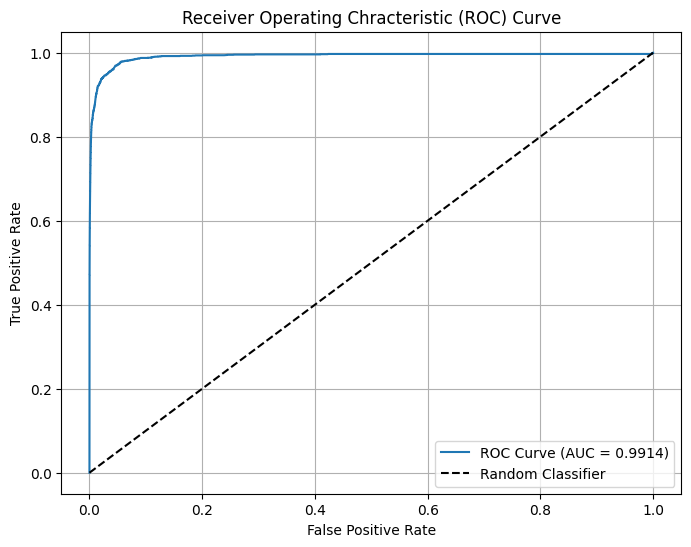

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

auc_score = roc_auc_score(y_test, pred_3)

fpr, tpr, thresholds = roc_curve(y_test, pred_3)

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Chracteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()